# Image Classification

In [1]:
import os
from pathlib import Path
import sys

from typing import List,Dict,Optional,Union,Tuple,Any,Iterable

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import wandb

from torchvision import transforms

import numpy as np
from scipy import stats
from tqdm.notebook import tqdm,trange

import time

import pickle
import matplotlib.pyplot as plt

In [2]:
def timeit(func):
    
    def wrapped_func(*args,**kwargs):
        
        start = time.perf_counter()
        res = func(*args,**kwargs)
        end = time.perf_counter()
        
        print(f"{func.__name__} took {(end-start):>1f}s to run")
    
    return wrapped_func

## Loading the Data

### CIFAR 10

    Image classification dataset with 10 classes
    
    Classes : 10
    Train   : 50,000
    Test    : 10,000

In [3]:
class Cifar10(Dataset):
    
    def __init__(self,data_dir:str,train:bool=True,transform=None,label_transform=None):
        
        self.data_dir = data_dir
        
        self.Xs = np.array([])
        self.ys = np.array([])
        self.names = {}
        
        self.transform = transform
        self.label_transform = label_transform

        self.label_names = {  
            0: "airplane",
            1: "automobile",
            2: "bird",
            3: "cat",
            4: "deer",
            5: "dog",
            6: "frog",
            7: "horse",
            8: "ship" ,
            9: "truck",
        }
        
        def filename_to_name_idx(name):
            name = str(name).split('_')
            return name[-1],name[0]
        
        if train:
            files = filter(lambda file: 'data' in file, os.listdir(self.data_dir))
        else:
            files = filter(lambda file: 'test' in file, os.listdir(self.data_dir))

        count = 0
        for file in files:
            data,labels,names = self.unpickle(os.path.join(self.data_dir,file))
            if count == 0:
                self.Xs = np.array(data)
                self.ys = np.array(labels)
                count += 1
            else:
                self.Xs = np.vstack((self.Xs,data))
                self.ys = np.vstack((self.ys,labels))

            names = {idx:name for idx,name in map(filename_to_name_idx,names)}

            self.names.update(names)
        
        self.ys = self.ys.reshape(-1)
        assert self.Xs.shape[0]==self.ys.shape[0],f"Data and labels are not in same shape {self.Xs.shape,self.ys.shape}"
        
    def __len__(self) -> int:
        return self.Xs.shape[0]
    
    def __getitem__(self,idx) -> Tuple[np.ndarray,Union[int,np.ndarray]]:
        image = self.Xs[idx]
        label = self.ys[idx]
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        
        return image,label
    
    def show_example(self,idx:int) -> None:
        img,label = self.__getitem__(idx)
        plt.imshow(img.transpose(1,2,0))
        plt.title(self.label_names[label])
        plt.axis('off')
        plt.show()
        
    def show_random_example(self) -> None:
        idx = np.random.randint(0,self.__len__())
        self.show_example(idx)
        
    def get_random_grid(self,grid_size:int = 5,viz:bool=False) -> np.ndarray:
        
        idx = lambda : np.random.randint(0,len(self))
        img = np.concatenate([ np.concatenate( [ self[idx()][0].transpose(1,2,0) for _ in range(grid_size)] ,axis=1) for _ in range(grid_size) ],axis=0)
        if viz:
            fig = plt.figure(figsize=(7,7))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        else:
            return img
            
    @staticmethod
    def unpickle(filename:str) -> Any:
        with open(filename,'rb') as file:
            batch = pickle.load(file,encoding='bytes')
        
        try:
            labels = batch[b'labels']
            data = batch[b'data'].reshape(-1,3,32,32)
            names = batch[b'filenames']
        except:
            print(type(batch))
        
        return data,labels,names



In [4]:
data_dir = Path('../data/cifar-10-batches-py/')
files = os.listdir(data_dir)


#### Train/Val/Test split

In [5]:
ds_train = Cifar10(data_dir,transform=lambda x: (x-x.mean())/x.std())
ds_test = Cifar10(data_dir,train=False)

split = 0.9
train_set,val_set = torch.utils.data.random_split(
    ds_train,
    ( int(len(ds_train)*(split)) , int(len(ds_train)*(1-split)) + 1 )
)

#### Using Pytorch Dataset and Dataloader for ease access

In [6]:
Bs = 32

train_loader = DataLoader(
    dataset=train_set,
    batch_size=Bs,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_set,
    batch_size=Bs,
    shuffle=True
)

test_loader = DataLoader(
    dataset=ds_test,
    batch_size=Bs,
    shuffle=True
)

loaders = {
    "train" : train_loader,
    "val" : val_loader,
    "test" : test_loader
}

datasets = {
    "train" : train_set,
    "val" : val_set,
    "test" : ds_test
}

## Classification

### k-NN classification
    
- Categorize all the training examples
- While Predicting -> find $k$ nearest neighours and return common class of the neighbours
    
#### Metrics

##### L1 distance
    Manhattan Distance
    Used where individual elements makes meaning like (emp salary, age, etc)
    
$$ L_{1} = \sum_{i=i}^{n}|{x_{i}}| $$ 

##### L2 distance (np default) 
    Forebinus norm, Euclid Distance
    
$$ L_{2} = \sqrt{\sum_{i=i}^{n}{|{x_{i}}|}^2} = \|x\|$$

In [27]:
class KNN:
    
    def __init__(self,dataset):
        
        self.dataset = dataset
        self.Xs,self.ys = self.dataset[:]
    
    def forward(self):
        # Just memorizing all the data
        pass
        
    def predict(self,img,metric:bool='l2',k:int=1,viz:bool=False,label=None):
        
        # ineffective
        if metric == 'l1':
            distances = np.sum(np.abs((self.Xs - img).reshape(self.Xs.shape[0],-1)),axis=-1)
        elif metric=='l2':
            distances = np.linalg.norm((self.Xs - img).reshape(self.Xs.shape[0],-1)**2,axis=-1)
            
        if k > 1:
            nearest_k = (-distances).argsort()[:k]
            nearest = nearest_k[0]
        else:
            nearest = distances.argmin(axis=0)
            pred = self.ys[nearest]
        
        if viz:
            fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,7))
            ax[0].imshow(self.Xs[nearest].transpose(1,2,0))
            ax[0].set_title(label)
            ax[1].imshow(img.transpose(1,2,0))
            ax[1].set_title(f"Pred as :{self.ys[nearest]}")
            plt.show()
            
        return self.ys[nearest]
    
    @timeit
    def test(self,size:int=1000):
        
        crct = 0
        
        # very ineffective cause for every n test example it has to find diff for M train examples
        for idx in np.random.randint(0,len(knn.dataset),(size)):
            img,label = knn.dataset[idx]
            aug_x = img + np.random.randint(0,150,(3,32,32))
            aug_x = 255 * (aug_x - aug_x.min())/(aug_x.max()-aug_x.min())
            
            res = self.predict(np.int32(aug_x),metric='l1',k=1,viz=True,label=label)
            crct += int(res == label)
        
        print(f"Acc : {crct/size *100}% for size {size}")
        
knn = KNN(train_set)

#### Test Runs

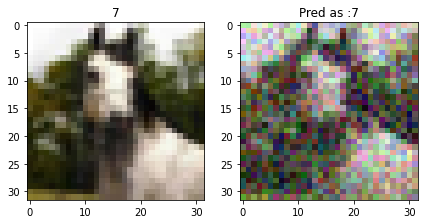

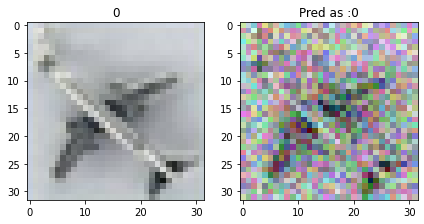

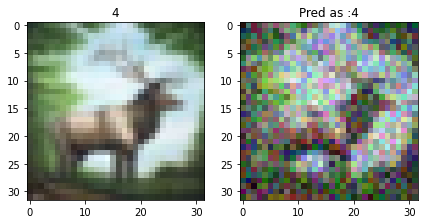

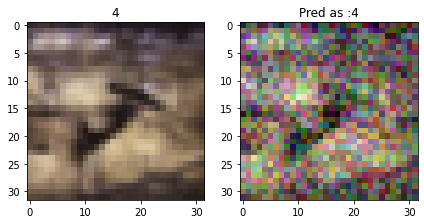

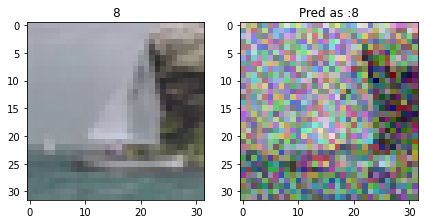

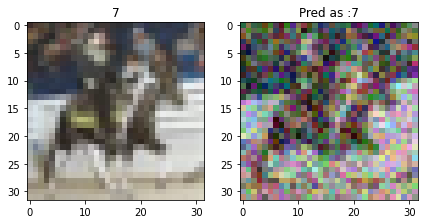

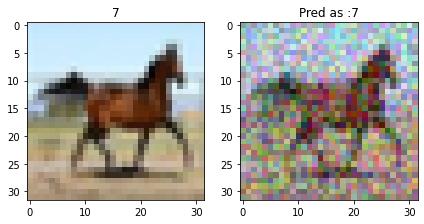

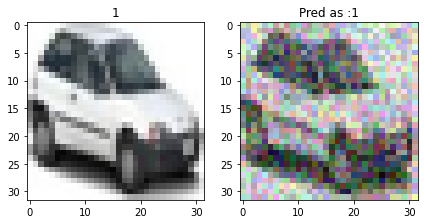

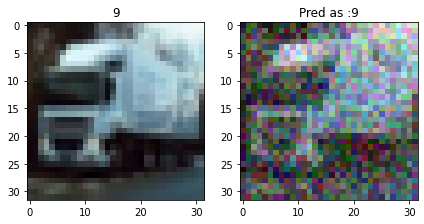

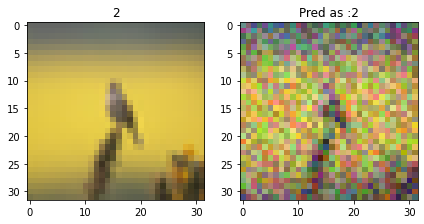

Acc : 100.0% for size 10
test took 3.404339s to run


In [28]:
knn.test(10)

### Linear

#### Parametric model
- Find a meaningful function h (linear)
- Find the best fiting $\theta$ for the given train set $X$
$$ \hat{y} = h(X,\theta) $$
- Define the Loss func $J$ such that the goal is
$$ \underset{\theta}{argmin}\ {J(X,\theta)} $$
- Traning with convex optimization $\eta$ is learning_rate
$$ \theta\ \leftarrow\ \theta - \eta.{J'(X,\theta))}$$

#### Linear Layer

- Notation
    
    - No. Example : $m,i$
    - No. feature : $n,j$
    - Input       : $X \in {\mathbb{R^{n*m}}}$
    - Label       : $y \in {\mathbb{R^{k}}}$ $k$ classes
    - Prediction  : $\hat{y}$
    - Weights.    : $\theta \in {\mathbb{R^{n*k}}}$
    - Biases.     : $b \in {\mathbb{R^{n*1}}}$
    - Loss fn     : $J$
    - L.Rate      : $\eta$
- hypothesis is kinda a straight line eqation
$$ h(X,\theta,b) = \theta^TX\ + b = \hat{y}$$
- Loss function is MSE  where $\lambda$ is regularization
$$ J(y,\hat{y}) = \frac{1}{2m}\sum_{i=1}^{m}\sum_{j=1}^{n}{(y_{j}^{(i)}-\hat{y}_{j}^{(i)})}^2 + \frac{\lambda}{2m}\sum_{j=1}^{n}(\theta_j)^2$$
- Optimization : SGD
$$ \theta_j \leftarrow \theta_j - \eta.{J'(y,\hat{y})_\theta}$$
$$ b_j \leftarrow b_j - \eta.{J'(y,\hat{y})_b}$$

$$ J'_\theta = \frac{2}{M} \displaystyle\sum^{M}_{i=0} {(\hat{y}^{(i)} - y^{(i)}) X^{(i)}} $$
$$ J'_b = \frac{2}{M} \displaystyle\sum^{M}_{i=0} {(\hat{y}^{(i)} - y^{(i)}).1} $$

In [7]:
class LinearRegression:
    
    def __init__(self,n:int,learning_rate=0.001,datasets = None,loaders = None,bias:bool=False):
        if datasets is not None:
            self.trainSet = datasets["train"]
            self.valSet = datasets["val"]
            self.testSet = datasets["test"]
        
        if loaders is not None:
            self.trainLoader = loaders['train']
            self.valLoader = loaders['val']
            self.testLoader = loaders['test']
        
        self.W = np.random.randn(n,1)
        self.B = np.random.randn(1,1)
        self.lr = learning_rate
    
    def forward(self,X):
        # f(W,X,b) = W^t.X + b
        return np.dot(self.W.T,X)+self.B
    
    def trainStep(self,X,y):
        X = X.reshape(-1,32)
        yhat = self.forward(X).T
        
        J = (np.square(yhat - y.reshape(-1,1))).mean()
#         acc = (yhat == y).mean()
        
        # gradient step
        dW = 2*np.dot(X,(yhat-y.reshape(-1,1))).mean()
        db = 2*((yhat-y.reshape(-1,1))).mean()
        
        self.W -= self.lr*dW
        self.B -= self.lr*db
        
        return J
    
    def trainLoop(self,N:int,viz:bool=False):
        
        Js = []
        for i in range(N):
            t = tqdm(self.trainLoader)
            for X,y in t:
                X,y = X.numpy(),y.numpy()
                if(X.shape[0]!=32): continue
                J = self.trainStep(X,y)
                t.desc = f"Loss : {J:>3f} "

                Js.append(J)

        Js = np.array(Js)
        
        if viz:
            plt.plot(np.arange(1,Js.shape[0]+1),Js,color='red',label="Loss")
#             plt.plot(np.arange(1,accs.shape[0]+1),accs,color='blue',label="Accuracy%")
            plt.title(f"Training performance {Js.mean()}")
            plt.legend()
            plt.show()
        

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

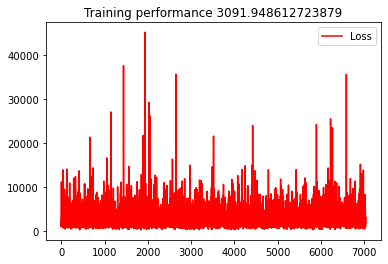

In [8]:
lr = LinearRegression(n=(3*32*32),datasets=datasets,loaders=loaders,bias=True)

x,y = train_set[:32]
lr.trainLoop(5,viz=True)

No learning in with linear regression even after 5 epochs

##### NN layer with pytorch

In [15]:
class LR(nn.Module):
    
    def __init__(self,inSize,outSize,bias=False,lr=0.001):
        super(LR,self).__init__()
        
        self.layer = nn.Linear(inSize,outSize)
        self.lr = lr
        
        self.optimizer = optim.Adam(self.layer.parameters(),lr=self.lr)
        self.loss_fn = nn.MSELoss()
        
    def forward(self,x):
        return self.layer(x)
    
    def trainStep(self,X,y):
        yhat = self.forward(X)
        
        J = self.loss_fn(yhat,y)
        
#         with self.train():
        self.optimizer.zero_grad()
        J.backward()
        self.optimizer.step()
        
        return J.detach()
            
    def trainLoop(self,N=1,viz=False):
        Js = []
        
        for b in range(N):
            t = tqdm(train_loader)
            for X,y in t:
                X = X.view(32,-1).float()
                y = y.view(-1,1).float()
                if(X.shape[1] != (3*32*32)):break
                J = self.trainStep(X,y)
                Js.append(J)
                t.desc = f"Loss {J:>3f} "
        
        Js = np.array(Js)
        if viz:
            plt.plot(np.arange(1,Js.shape[0]+1),Js,color='red',label="Loss")
#             plt.plot(np.arange(1,accs.shape[0]+1),accs,color='blue',label="Accuracy%")
            plt.title(f"Training performance {Js.mean()}")
            plt.legend()
            plt.show()
            
                
            
    

In [16]:
model = LR(3*32*32,1,True,lr=0.01)

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

  0%|          | 0/1407 [00:00<?, ?it/s]

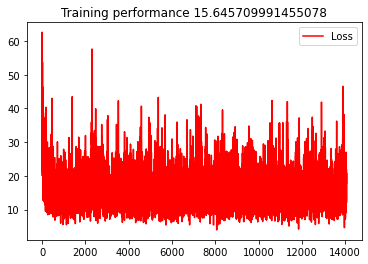

In [17]:
model.trainLoop(10,viz=True)